<a href="https://colab.research.google.com/github/KalyaniHaridas/sampleweb/blob/master/Copy_of_Worshop_Hands_on_Day_3_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Teleportation
Recall the protocol!

We have

$\rightarrow$ Alice and Bob

$\rightarrow$ Alice wants to teleport a quantum state $|\psi\rangle = \alpha |0\rangle + \beta|1\rangle$ to Bob.

$\rightarrow$ The resouce that they have is an entangled pair of qubits say a bell pair.

Let us first set these up!


In [81]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
pip install qiskit.ignis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector


 Lets create an bell pair for Alice and Bob!
 
 Define a function that returns a quantum circuit that generates a bell pair of the form $\dfrac{1}{2}|00\rangle + |11\rangle$ 


In [84]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    return qc

In [85]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# Let us create entanglement between qubits q1 and q2 for Alice and Bob
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()


q_0: ──────────
     ┌───┐     
q_1: ┤ H ├──■──
     └───┘┌─┴─┐
q_2: ─────┤ X ├
          └───┘
crz: ══════════
               
crx: ══════════

Alice takes q1 and Bob q2 and they part ways!

Alice then decides she wants to teleport a quantum state to Bob!

Say she wants to teleport the state $\dfrac{1}{\sqrt(2)}|0\rangle - \dfrac{1}{\sqrt(2)}|1\rangle$

Initialize the q0 in the required state

In [86]:
teleportation_circuit.initialize([1/np.sqrt(2), -1/np.sqrt(2)], 0)

In [87]:
teleportation_circuit.draw()

┌──────────────────────────────┐     
q_0: ┤ Initialize(0.70711,-0.70711) ├─────
     └────────────┬───┬─────────────┘     
q_1: ─────────────┤ H ├────────────────■──
                  └───┘              ┌─┴─┐
q_2: ────────────────────────────────┤ X ├
                                     └───┘
crz: ═════════════════════════════════════
                                          
crx: ═════════════════════════════════════

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$.
In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [88]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [89]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [90]:
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

┌──────────────────────────────┐          ┌───┐ ░ ┌─┐   
q_0: ┤ Initialize(0.70711,-0.70711) ├───────■──┤ H ├─░─┤M├───
     └────────────┬───┬─────────────┘     ┌─┴─┐└───┘ ░ └╥┘┌─┐
q_1: ─────────────┤ H ├────────────────■──┤ X ├──────░──╫─┤M├
                  └───┘              ┌─┴─┐└───┘      ░  ║ └╥┘
q_2: ────────────────────────────────┤ X ├───────────░──╫──╫─
                                     └───┘           ░  ║  ║ 
crz: ═══════════════════════════════════════════════════╩══╬═
                                                           ║ 
crx: ══════════════════════════════════════════════════════╩═

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [91]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [92]:
## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

┌──────────────────────────────┐          ┌───┐ ░ ┌─┐    ░           
q_0: ┤ Initialize(0.70711,-0.70711) ├───────■──┤ H ├─░─┤M├────░───────────
     └────────────┬───┬─────────────┘     ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░           
q_1: ─────────────┤ H ├────────────────■──┤ X ├──────░──╫─┤M├─░───────────
                  └───┘              ┌─┴─┐└───┘      ░  ║ └╥┘ ░ ┌───┐┌───┐
q_2: ────────────────────────────────┤ X ├───────────░──╫──╫──░─┤ X ├┤ Z ├
                                     └───┘           ░  ║  ║  ░ └─╥─┘└─╥─┘
crz: ═══════════════════════════════════════════════════╩══╬══════╬════■══
                                                           ║      ║   0x1 
crx: ══════════════════════════════════════════════════════╩══════■═══════
                                                                 0x1

In [93]:
# Let us simulate this circuit 
# Configuring account
IBMQ.save_account("0494143348313b109e0a5383fe6b7ebad418b05840611bb70b3508c0932ea7f1a935b1c5a35296b49b4da40b3ec1c0b17233b994747d06e0f8555076cd6850ee")
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2022-10-19 10:47:57,287: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-10-19 10:47:57,431: Credentials are already in use. The existing account in the session will be replaced.


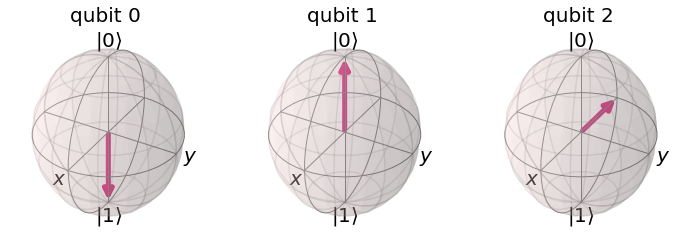

In [94]:
sim = Aer.get_backend('aer_simulator')
teleportation_circuit.save_statevector()
out_vector = sim.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

## Understanding the theory of Quantum Teleportation <a id="understanding-qt"></a>

From Qiskit Textbook

As you have worked with the Quantum Teleportation's implementation, it is time to understand the mathematics behind the protocol.

#### Step 1

Quantum Teleportation begins with the fact that Alice needs to transmit $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ (a random qubit) to Bob. She doesn't know the state of the qubit. For this, Alice and Bob take the help of a third party (Telamon). Telamon prepares a pair of entangled qubits for Alice and Bob. The entangled qubits could be written in Dirac Notation as:

$$ |e \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively),

$$|e\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B) $$

This creates a three qubit quantum system where Alice has the first two qubits and Bob the last one.

$$ \begin{align*}
|\psi\rangle \otimes |e\rangle &= \frac{1}{\sqrt{2}} (\alpha |0\rangle \otimes (|00\rangle + |11\rangle) + \beta |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) 
\end{align*}$$

#### Step 2

Now according to the protocol Alice applies CNOT gate on her two qubits followed by Hadamard gate on the first qubit. This results in the state:

$$ 
\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|\psi\rangle \otimes |e\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|110\rangle + \beta|101\rangle) \\
&= \frac{1}{2}  (\alpha(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}
$$

Which can then be separated and written as: 

$$
\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (\alpha|0\rangle + \beta|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (\alpha|1\rangle + \beta|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (\alpha|0\rangle - \beta|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (\alpha|1\rangle - \beta|0\rangle) \quad )\\
\end{align*}
$$

#### Step 3

Alice measures the first two qubit (which she owns) and sends them as two classical bits to Bob. The result she obtains is always one of the four standard basis states $|00\rangle, |01\rangle, |10\rangle,$ and $|11\rangle$ with equal probability.  

On the basis of her measurement, Bob's state will be projected to, 
$$ |00\rangle \rightarrow (\alpha|0\rangle + \beta|1\rangle)\\
|01\rangle \rightarrow (\alpha|1\rangle + \beta|0\rangle)\\
|10\rangle \rightarrow (\alpha|0\rangle - \beta|1\rangle)\\
|11\rangle \rightarrow (\alpha|1\rangle - \beta|0\rangle)$$.

#### Step 4

Bob, on receiving the bits from Alice, knows he can obtain the original state $|\psi\rangle$ by applying appropriate transformations on his qubit that was once part of the entangled pair.

The transformations he needs to apply are:

$$
\begin{array}{c c c}
\mbox{Bob's State}                 & \mbox{Bits Received} & \mbox{Gate Applied} \\
(\alpha|0\rangle + \beta|1\rangle) & 00                   & I                   \\
(\alpha|1\rangle + \beta|0\rangle) & 01                   & X                   \\
(\alpha|0\rangle - \beta|1\rangle) & 10                   & Z                   \\
(\alpha|1\rangle - \beta|0\rangle) & 11                   & ZX
\end{array}
$$

After this step Bob will have successfully reconstructed Alice's state.

## Take home task:  Quantum teleportation using GHZ like state  

This exercise is based on the idea in reference https://www.cs.memphis.edu/~kanyang/paper/J1-IJTP.pdf
In this teleportation protocol, Alice distributes a GHZ like state given as \begin{equation}
\dfrac{1}{2}[|001\rangle + |010\rangle +|100\rangle] + |111\rangle\end{equation}

The state that she would like to transfer is say $\alpha |0\rangle + \beta|1\rangle$

This state can either be transfered to Bob or Charlie while the other party acts as an controller.

### Task 1 :
Create the GHZ like state -
$$\dfrac{1}{2}[|001\rangle + |010\rangle +|100\rangle] + |111\rangle$$
Follow the procedure given in the reference and create a circuit that generates the state 

In [ ]:
## Create the GHZ like state in qubits 1,2,3 the qubit 0 will be the state 





### Task 2: Next let us teleport the state from Alice  to Charlie
 Follow the procedure in the reference and get the state teleported from the first qubit to the last.
 You would essentially do the following
 1. Do a bell measurement on the first two qubits with Alice
 2. Do a Z basis measurement on the third qubit, the qubit with Bob
 3. Based on the results from Alice's Bell measurement and Bob's Z basis measurement apply local unitary on Charlies qubit and show that the state is successfully teleported


## Grover Search

In [61]:
#Importing standard qiskit libraries and other required libraries
import numpy as np
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#Load your IBMQ account
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-19 10:46:03,846: Credentials are already in use. The existing account in the session will be replaced.


In [62]:
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt

In [63]:
n=4
grover_qc = QuantumCircuit(n+1,n)
marked = [1,0,1,1]

In [64]:
def oracle(n,marked,qc):
    flip0 = [i for i in range(n) if not marked[i]]
    qc.x(flip0)
    qc.mct(list(range(n)),n)
    qc.x(flip0)
    qc.draw()

In [65]:
def reflect_mean(qc,n):
    qc.h(list(range(n)))
    qc.x(list(range(n)))
    qc.mct(list(range(n)),n)
    qc.x(list(range(n+1)))
    qc.h(list(range(n)))
    pass

In [66]:
grover_qc.x(n)
grover_qc.barrier()
grover_qc.h(list(range(n+1)))

In [67]:
grover_qc.draw()

░ ┌───┐
q_0: ──────░─┤ H ├
           ░ ├───┤
q_1: ──────░─┤ H ├
           ░ ├───┤
q_2: ──────░─┤ H ├
           ░ ├───┤
q_3: ──────░─┤ H ├
     ┌───┐ ░ ├───┤
q_4: ┤ X ├─░─┤ H ├
     └───┘ ░ └───┘
c_0: ═════════════
                  
c_1: ═════════════
                  
c_2: ═════════════
                  
c_3: ═════════════

In [68]:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_qc)
result=svsim.run(qobj).result()
statevector = result.data()['statevector']
statevector = np.asarray(statevector)
statevector = statevector[:2**n]

In [69]:
ket_a=np.zeros(2**n)
ket_a[13]=1
ket_e = (np.ones(2**n)-ket_a)/np.sqrt(2**n-1)

In [70]:
def get_projection(psi,e,a):
    proj = [np.real(np.vdot(e,psi)), np.real(np.vdot(a,psi))]
    return proj
def plt_vector(proj, axes = [0.0,1.0,0.0,1.0]):
    x_pos = 0
    y_pos = 0
    x_direct = proj[0]
    y_direct = proj[1]
    
    #creating plot
    fig, ax = plt.subplots()
    ax.quiver(x_pos, y_pos, x_direct, y_direct, scale=1.0)
    
    ax.axis(axes)
    
    plt.show()

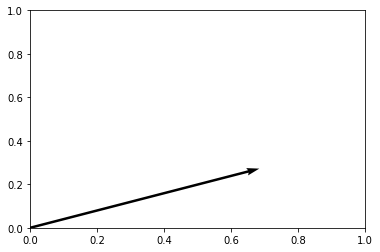

In [71]:
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj)

In [72]:
oracle(4,marked,grover_qc)
grover_qc.barrier()

In [73]:
grover_qc.draw()

░ ┌───┐                ░ 
q_0: ──────░─┤ H ├───────■────────░─
           ░ ├───┤┌───┐  │  ┌───┐ ░ 
q_1: ──────░─┤ H ├┤ X ├──■──┤ X ├─░─
           ░ ├───┤└───┘  │  └───┘ ░ 
q_2: ──────░─┤ H ├───────■────────░─
           ░ ├───┤       │        ░ 
q_3: ──────░─┤ H ├───────■────────░─
     ┌───┐ ░ ├───┤     ┌─┴─┐      ░ 
q_4: ┤ X ├─░─┤ H ├─────┤ X ├──────░─
     └───┘ ░ └───┘     └───┘      ░ 
c_0: ═══════════════════════════════
                                    
c_1: ═══════════════════════════════
                                    
c_2: ═══════════════════════════════
                                    
c_3: ═══════════════════════════════

In [74]:
reflect_mean(grover_qc,n)
grover_qc.barrier()

In [75]:
grover_qc.draw()

░ ┌───┐                ░ ┌───┐┌───┐     ┌───┐┌───┐ ░ 
q_0: ──────░─┤ H ├───────■────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
           ░ ├───┤┌───┐  │  ┌───┐ ░ ├───┤├───┤  │  ├───┤├───┤ ░ 
q_1: ──────░─┤ H ├┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
           ░ ├───┤└───┘  │  └───┘ ░ ├───┤├───┤  │  ├───┤├───┤ ░ 
q_2: ──────░─┤ H ├───────■────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
           ░ ├───┤       │        ░ ├───┤├───┤  │  ├───┤├───┤ ░ 
q_3: ──────░─┤ H ├───────■────────░─┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
     ┌───┐ ░ ├───┤     ┌─┴─┐      ░ └───┘└───┘┌─┴─┐├───┤└───┘ ░ 
q_4: ┤ X ├─░─┤ H ├─────┤ X ├──────░───────────┤ X ├┤ X ├──────░─
     └───┘ ░ └───┘     └───┘      ░           └───┘└───┘      ░ 
c_0: ═══════════════════════════════════════════════════════════
                                                                
c_1: ═══════════════════════════════════════════════════════════
                                                                
c_2: ═══════════════════════════════════════════════════════════
                                                                
c_3: ═══════════════════════════════════════════════════════════

In [76]:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_qc)
result=svsim.run(qobj).result()
statevector = result.data()['statevector']
statevector = np.asarray(statevector)
statevector = statevector[:2**n]

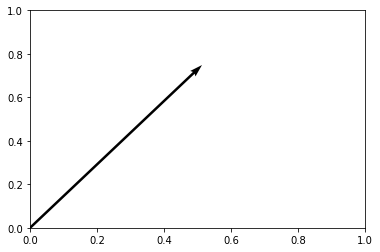

In [77]:
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj)

In [78]:
oracle(4,marked,grover_qc)
grover_qc.barrier()
reflect_mean(grover_qc,n)
grover_qc.barrier()

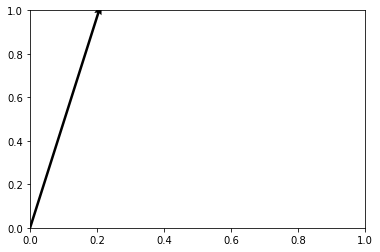

In [79]:
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_qc)
result=svsim.run(qobj).result()
statevector = result.data()['statevector']
statevector = np.asarray(statevector)
statevector = statevector[:2**n]
proj = get_projection(statevector, ket_e, ket_a)
plt_vector(proj)

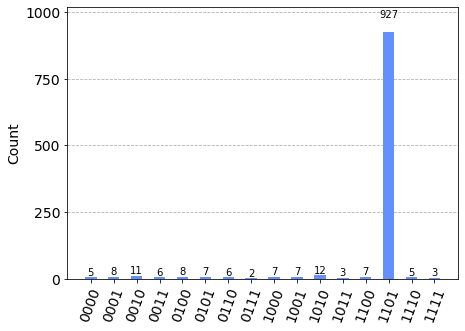

In [80]:
grover_qc.measure(range(n),range(n))

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)
